# Chilling Effects Replication

This notebook will attempt to replicate the figure 3 and figure 4A from paper `Chilling effects`.

<!-- <img src="images/Figure3.png" width=500> -->

## Figure 3

### Importing the data

First what we will do is import the data from the provided dataset `terrorism_data.csv`.
While importig the data, we parse dates from the `date` column so that they can be processed more efficiently afterwards.
Then we will remove the `language` column as all articles are extracted from english wiki, so it does not provide usefull information.
Finally we display the DataFrame to explore how the data is arranged.

In [1]:
from IPython.display import display, Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_FOLDER = './data/'
TERRORISM = 'terrorism_data.csv'
DOMESTIC = 'domestic_data.csv'

# load terrrorism data
article_views = pd.read_csv(DATA_FOLDER+TERRORISM, index_col='Unnamed: 0', parse_dates=['date'])


# drop columns that are not interesting
article_views.drop(columns='language', inplace=True)
article_views.head(10)

,article,date,views
11000,abu_sayyaf,2012-01-01,254
1355,afghanistan,2012-01-01,5241
1369,agro,2012-01-01,27
1,al-qaeda,2012-01-01,2688
13457,al-qaeda_in_the_arabian_peninsula,2012-01-01,104
13460,al-qaeda_in_the_islamic_maghreb,2012-01-01,8
13484,al-shabaab,2012-01-01,951
1800,ammonium_nitrate,2012-01-01,670
1346,attack,2012-01-01,93
1700,biological_weapon,2012-01-01,63


### Exploring the data

We see that each row is the daily view count of an article. We will verify that our dataset includes all 48 articles from the study. The themes depicted in these articles should be closely related to 'terrorism'.

In [2]:
gb_articles = article_views.groupby(by='article')
article_names = gb_articles.groups
nb_articles = len(article_names)
print(f'Article subjects are : \n{", ".join(article_names)}.')
print(f'\nNumber of articles is : {nb_articles}')

Article subjects are : 
abu_sayyaf, afghanistan, agro, al-qaeda, al-qaeda_in_the_arabian_peninsula, al-qaeda_in_the_islamic_maghreb, al-shabaab, ammonium_nitrate, attack, biological_weapon, car_bomb, chemical_weapon, conventional_weapon, dirty_bomb, eco-terrorism, environmental_terrorism, euskadi_ta_askatasuna, extremism, farc, fundamentalism, hamas, hezbollah, improvised_explosive_device, iran, iraq, irish_republican_army, islamist, jihad, nationalism, nigeria, nuclear, nuclear_enrichment, pakistan, palestine_liberation_front, pirates, plo, political_radicalism, recruitment, somalia, suicide_attack, suicide_bomber, taliban, tamil_tigers, tehrik-i-taliban_pakistan, terror, terrorism, weapons-grade, yemen.

Number of articles is : 48


Now let's explore the date range and see wether our data covers the same periode as the papers which is from January 2012 to August 2014 (included).

In [3]:
start = article_views.date.min()
finish = article_views.date.max()
print(f'The data starts at : {start.strftime("%d %B %Y")}')
print(f'The data ends at : {finish.strftime("%d %B %Y")}')
nb_months = (finish.year-start.year)*12+(finish.month-start.month)+(finish.day-start.day)/31
print(f'There are {nb_months:.0f} months in the study')

The data starts at : 01 January 2012
The data ends at : 31 August 2014
There are 32 months in the study


And it does. This is all good.
Now we will analyse our data according to the method provided in the paper.

### Analysis

Here we will try to replicate what the authors of the paper did. We will then discuss the discrepancies and their origin.

We start by plotting the monthly sum of views of the raw data.

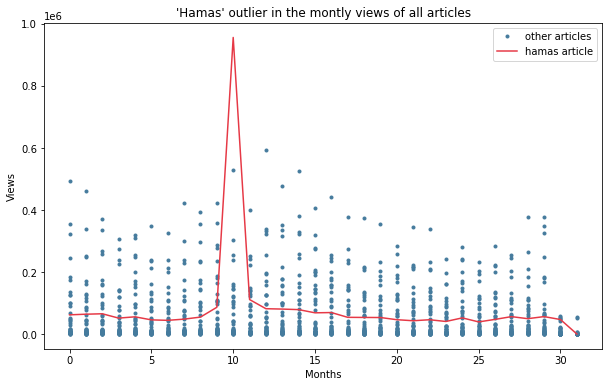

In [4]:
# plot
outlier = 'hamas'
fig = plt.figure(figsize=(10, 6))

for i, (article_name, df_article) in enumerate(gb_articles):
    if not i:
        views_month = df_article.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()
        plt.plot(views_month.index, views_month.views, '.', color='#457B9D', label='other articles')
    elif article_name != outlier:
        views_month = df_article.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()
        plt.plot(views_month.index, views_month.views, '.', color='#457B9D')

# get hamas group and plot it differently
df_article = gb_articles.get_group(outlier)
views_month = df_article.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()
plt.plot(views_month.index, views_month.views, color='#E63946', label='hamas article')

# set legend, axis labels and title
plt.legend(loc="upper right")
plt.xlabel('Months')
plt.ylabel('Views')
plt.title("'Hamas' outlier in the montly views of all articles")
plt.show()

The figure above clearly shows the presence of an outlier in the provided data. We want to get rid of this outlier as the authors of the paper did. The explanation given in the paper is that War and conflicts in the Midlle East caused an extreme increase of the views on the 'hamas' article. We will remove this article from our study dataset.

Now we show the impact on the monthly views with and without the 'hamas' article.

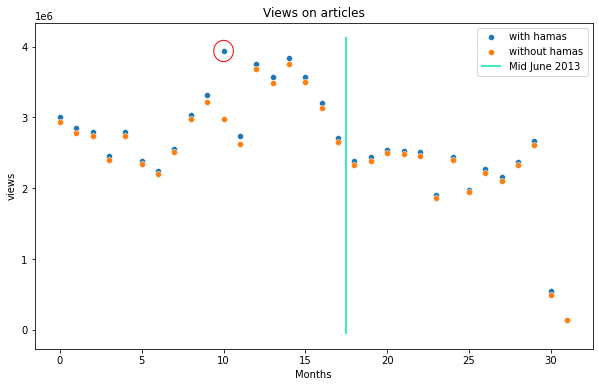

In [5]:
from matplotlib.patches import Ellipse

# set figure
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

# sum all articles over months
all_views_month = article_views.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()

sns.scatterplot(x=all_views_month.index, y='views', data=all_views_month, ax=ax)

# drop hamas
article_views_clean = article_views[article_views.article != 'hamas']
all_views_month_clean = article_views_clean.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()

sns.scatterplot(x=all_views_month_clean.index, y='views', data=all_views_month_clean, ax=ax)

# vertical line to separate before and after June 2013
lims = ax.get_ylim()
plt.vlines(x=17.5, ymin=min(lims), ymax=max(lims), color='#01e5a7')

# plot a circle around the outlier
outlier_x = 10
outlier_point = Ellipse((outlier_x, all_views_month.iloc[outlier_x].views), 1.2, 0.3e6, color='r', fill=False)
ax.add_artist(outlier_point)

# set the legend and title 
ax.legend(['with hamas', 'without hamas', 'Mid June 2013'])
ax.set_title('Views on articles')
ax.set(xlabel='Months')

plt.show()

And the figure shows that the general trend in data isn't changed by the removal of the 'hamas' data since the points only shift down by approximately the same amount.

### Regression

We will now be computing the linear regressions on both periodes in this section. We will use `LinearRegression` model from scikit-learn.

In [6]:
from sklearn.linear_model import LinearRegression
import numpy as np

# function to plot the replication figure
def plot_replication(df, mid=17, idx_max=32, offs=1):
    """
    :param df: datafram with the data
    :param mid: separating value to use
    :param idx_max: maximum index to use
    :param offs: offset the values on the ploting axis
    """
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot()

    reg_before = LinearRegression()
    reg_after = LinearRegression()
    before_range = np.arange(mid)
    after_range = np.arange(mid, idx_max)

    reg_before.fit(before_range.reshape(-1,1)+offs, df.iloc[before_range].views)
    reg_pred_before = reg_before.predict(before_range.reshape(-1,1)+offs)

    reg_after.fit(after_range.reshape(-1,1)+offs, df.iloc[after_range].views)
    reg_pred_after = reg_after.predict(after_range.reshape(-1,1)+offs)

    plt.plot(before_range+offs, reg_pred_before, linewidth=3, label="Trend Pre-June 2013", zorder=1)
    plt.plot(after_range+offs, reg_pred_after, linewidth=3, label="Trend Post-June 2013", zorder=1)
    plt.scatter(np.arange(idx_max)+offs, df.iloc[np.arange(idx_max)].views, color='#000000', label="Total article views", zorder=2)

    lims = ax.get_ylim()
    plt.vlines(x=mid-0.5+offs, ymin=min(lims), ymax=max(lims), color='#222222', label="Mid June 2013")

    ax.set_xticks(np.arange(0, idx_max+1, 2))
    ax.set_title("Mid June 2013")
    ax.set_xlabel("Time (Months)")
    ax.set_ylabel("Total Views (47 Wikipedia articles, Hamas excluded)")
    plt.legend(loc="lower left", ncol=2, framealpha=1)
    plt.grid(which='major', axis='y')
    plt.show()
    
    # extract interesting results
    print(f'The slope before the event is {reg_before.coef_[0]:.0f}')
    print(f'The slope after the event is {reg_after.coef_[0]:.0f}')
    print(f'The drop in views between the prediction and actual view is {abs(reg_before.predict([[mid]])[0]-df.iloc[mid].views):.0f}')

Here we replicate the figure with all the data given (32 months).

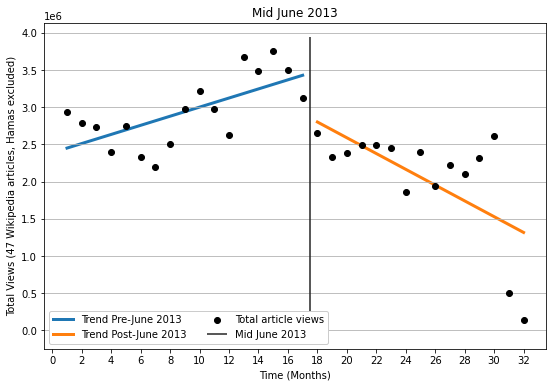

The slope before the event is 61187
The slope after the event is -106097
The drop in views between the prediction and actual view is 781084


In [7]:
plot_replication(all_views_month_clean)

We see on the graph that the 2 last months of the data are really low and they do not get well with the other months. We will drop them to see the difference.

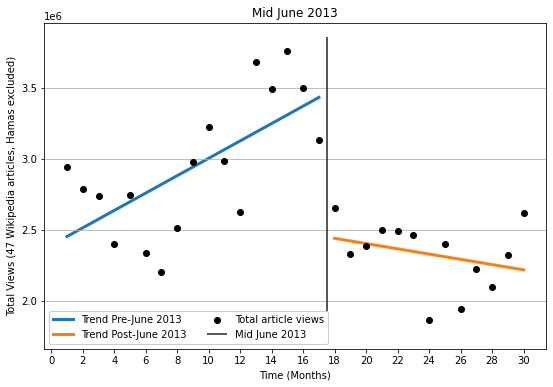

The slope before the event is 61187
The slope after the event is -18476
The drop in views between the prediction and actual view is 781084


In [8]:
plot_replication(all_views_month_clean, idx_max=30)

According to table 2 in the paper, the slope before was 47038, slope after was -35517 and the change in views was (-)995085.

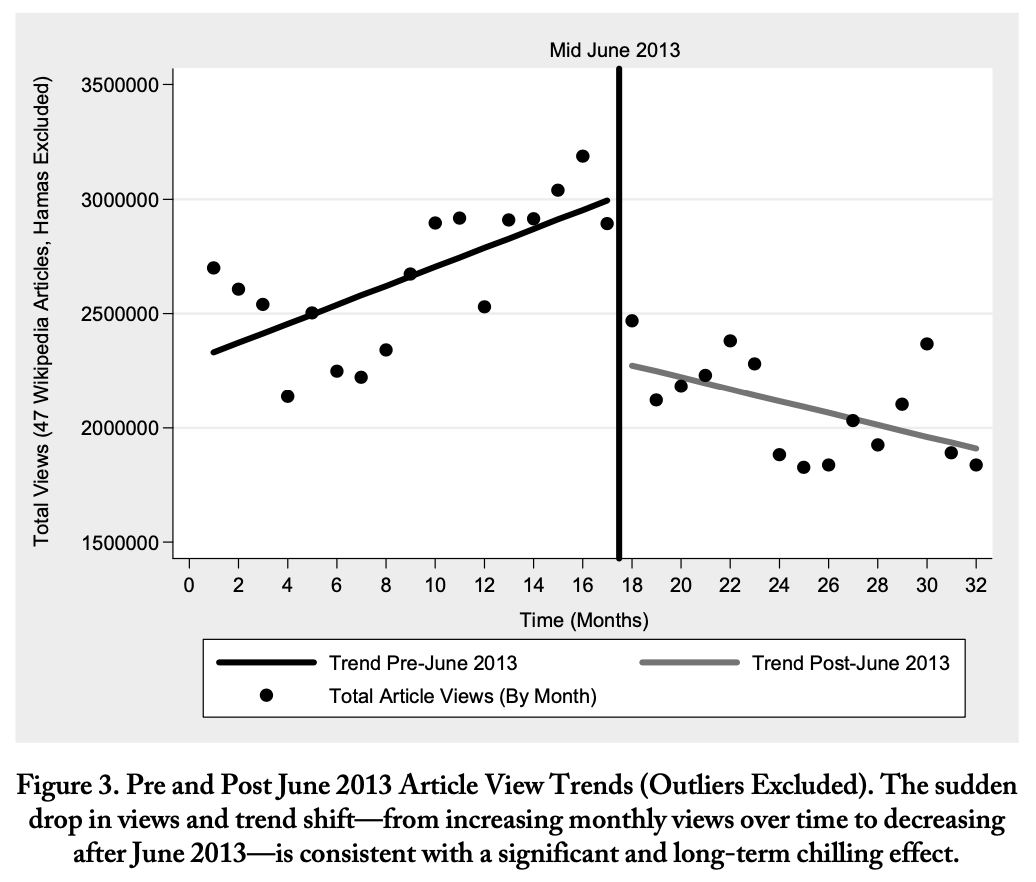

In [9]:
display(Image(filename='./images/Figure3.png', width=500))

### Discussion 

These numbers don't quite match with the recreation that I have presented in the figure above mainly because the raw data was not the same. But I tried my best to replicate the result using the same method. The main takaway here is that the fondamental results are the same, we can safely say that the events of June 2013 have had a clear chilling effect on Wikipedia users.

---


## Figure 4A

In this section we will recreate the figure 4A of the paper 'Chilling effects'.

### Importing the data

In [10]:
# load terrrorism data
domestic_views = pd.read_csv(DATA_FOLDER+DOMESTIC, index_col='Unnamed: 0', parse_dates=['date'])

# drop columns that are not interesting
domestic_views.drop(columns='language', inplace=True)
domestic_views.head(10)

,article,date,views
1900,air_marshal,2012-01-01,383
1590,alcohol_and_tobacco_tax_and_trade_bureau,2012-01-01,64
1349,border_patrol,2012-01-01,38
1358,bureau_of_land_management,2012-01-01,135
1390,central_intelligence_agency,2012-01-01,2964
1343,coast_guard,2012-01-01,234
1346,customs_and_border_protection,2012-01-01,25
1460,dea,2012-01-01,210
12000,emergency_management,2012-01-01,1120
1369,espionage,2012-01-01,1926


Here we see the data that was given to us for this analysis. We droped the language collumn as it was all english ('en') and we were not interested in this information.

### Exploring the data 

The given data should be about themes related to domestic-security subjects.

In [11]:
domestic_gb = domestic_views.groupby('article')
article_names = domestic_gb.groups
print(f'Article subjects in the domestic dataset are :\n{", ".join(article_names)}')
print(f'Number of articles in domestic dataset is : {len(article_names)}')

Article subjects in the domestic dataset are :
air_marshal, alcohol_and_tobacco_tax_and_trade_bureau, border_patrol, bureau_of_land_management, central_intelligence_agency, coast_guard, customs_and_border_protection, dea, emergency_management, espionage, federal_air_marshal_service, federal_aviation_administration, federal_bureau_of_investigation, federal_emergency_management_agency, fusion_center, homeland_defense, national_guard, secret_service, secure_border_initiative, task_force_88_(anti-terrorist_unit), transportation_security_administration, u.s._immigration_and_customs_enforcement, united_nations, united_states_citizenship_and_immigration_services, united_states_department_of_homeland_security
Number of articles in domestic dataset is : 25


This is the expected result. Articles are the same as the ones used in the paper. They are 25 in total and are domestic security-related articles.

We will now explore the date ranges and see if they match the timeperiode used for the analysis in the paper.

In [12]:
start_date = domestic_views.date.min()
end_date = domestic_views.date.max()
print(f'The data starts on the {start_date.strftime("%d %B %Y")}.')
print(f'The data ends on the {end_date.strftime("%d %B %Y")}.')
nb_months = (end_date.year-start_date.year)*12+(end_date.month-start_date.month)+(end_date.day-start_date.day)/31
print(f'There are {nb_months:.0f} months in the study.')

The data starts on the 01 January 2012.
The data ends on the 31 August 2014.
There are 32 months in the study.


These are the expected dates as seen in the replication of figure 3. The periode of 32 months is the same as in the paper.

### Analysis

Lets see the views per article to detect any ouliers

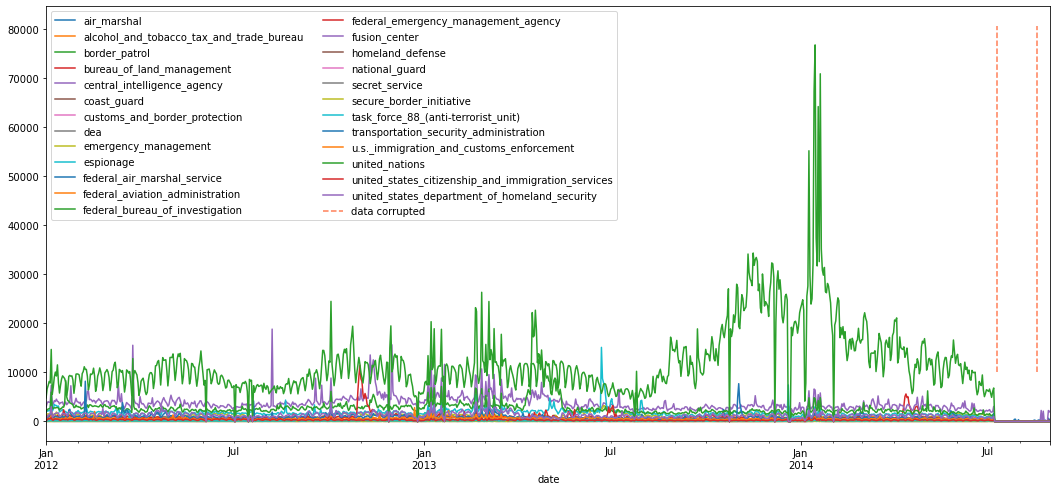

In [13]:
dom_piv = domestic_views.pivot_table(index='date', columns='article', values='views', fill_value=0)
ax = dom_piv.plot(figsize=(18, 8))

lims = ax.get_ylim()
plt.vlines(x=['2014-07-10', '2014-08-18'], ymin=10000, ymax=max(lims), color='#ff7e57', label="data corrupted", linestyle='dashed')
plt.legend(loc="upper left", ncol=2)
plt.show()

`United nations` is the most viewed article. Also there seems to be some kind of data corruption as the last 2 months exhibit an abnormal number of views.

### Aggregating views by month

Now we want to aggregate views by month and see them in a scatter plot.

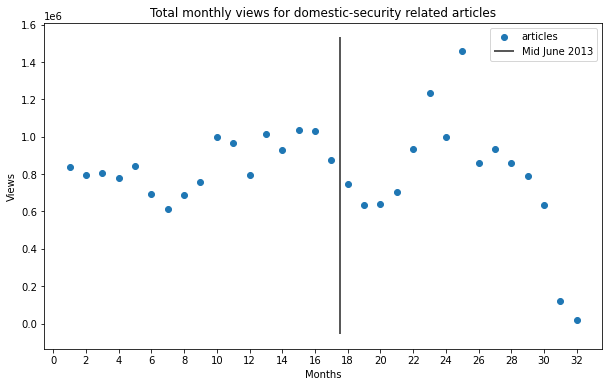

In [14]:
dom_views_month = domestic_views.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
ax.scatter(dom_views_month.index+1, dom_views_month.views, label='articles')
lims = ax.get_ylim()
plt.vlines(x=17.5, ymin=min(lims), ymax=max(lims), color='#222222', label="Mid June 2013")
ax.set_title('Total monthly views for domestic-security related articles')
ax.set_xlabel('Months')
ax.set_ylabel('Views')
ax.set_xticks(range(0, 34, 2))
ax.legend()

plt.show()

### Final figure

First we will write a funtion to compute confidence intervals with bootstraping

In [15]:
import numpy as np
# bootstraped condidence intervals
def get_ci(data, model, n_boots=1000, sample_size=100, ci=95):
    
    indices = np.arange(len(data))
    predictions = []
    for b in range(n_boots):
        sample = np.random.choice(indices, replace=True, size=sample_size)
        # select the data
        views = data.iloc[sample].views.to_numpy()
        # fit the model
        model.fit(sample.reshape(-1, 1), views.reshape(-1, 1))
        predictions.append(model.predict(indices.reshape(-1,1)))
    alpha_low = (100-ci)/2
    return np.percentile(predictions, alpha_low, axis=0).reshape(-1), np.percentile(predictions, 100-alpha_low, axis=0).reshape(-1)

This function plots a line and fills between the ci's on the given range of dates

In [16]:
def plot_reg_line_ci(df, id_range, offs, p_label, p_color=None, fill_label=None, fill_color='#ccc', alpha=0.5, sample_size=10):
    reg = LinearRegression()
    df_split = df.iloc[id_range]
    reg.fit(id_range.reshape(-1,1)+offs, df_split.views)
    reg_pred = reg.predict(id_range.reshape(-1,1)+offs)
    plt.plot(id_range+offs, reg_pred, linewidth=3, label=p_label, zorder=1, color=p_color)
    plt.fill_between(id_range+offs, *get_ci(df_split, reg, sample_size=sample_size), label=fill_label, alpha=alpha, color=fill_color)

In [17]:
# function to plot the replication figure
def plot_replication_4(terr_df, dom_df, mid=17, idx_max=32, offs=1, sample_size=10):
    """
    :param df: datafram with the data
    :param mid: separating value to use
    :param idx_max: maximum index to use
    :param offs: offset the values on the ploting axis
    """
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot()

    before_range = np.arange(mid)
    after_range = np.arange(mid, idx_max)
    
    plot_reg_line_ci(terr_df, before_range, offs, "Terrorism Trend Pre-June 2013", p_color='#007be0', fill_label='Confidence Interval (95%)')
    plot_reg_line_ci(terr_df, after_range, offs, "Terrorism Trend Post-June 2013", p_color='#5cb5ff')
    plot_reg_line_ci(dom_df, before_range, offs, "Security Trend Pre-June 2013", p_color='#ff9500')
    plot_reg_line_ci(dom_df, after_range, offs, "Terrorism Trend Post-June 2013", p_color='#ffb54d')
    r_idx = np.arange(idx_max)
    plt.scatter(r_idx+offs, terr_df.iloc[r_idx].views, color='#000000', label="Terrorism Total article views", zorder=2)
    plt.scatter(r_idx+offs, dom_df.iloc[r_idx].views, color='#888', label="Terrorism Total article views", zorder=2)
    
    lims = ax.get_ylim()
    plt.vlines(x=mid-0.5+offs, ymin=min(lims), ymax=max(lims), color='#222222', label="Mid June 2013")

    ax.set_xticks(np.arange(0, idx_max+1, 2))
    ax.set_yticks(np.arange(0, 4e6, 0.5e6))
    ax.set_title("Mid June 2013")
    ax.set_xlabel("Time (Months)")
    ax.set_ylabel("Total Views (All Articles)")
    plt.legend(loc="upper right", ncol=2, framealpha=1)
    plt.grid(which='major', axis='y')
    plt.show()
    

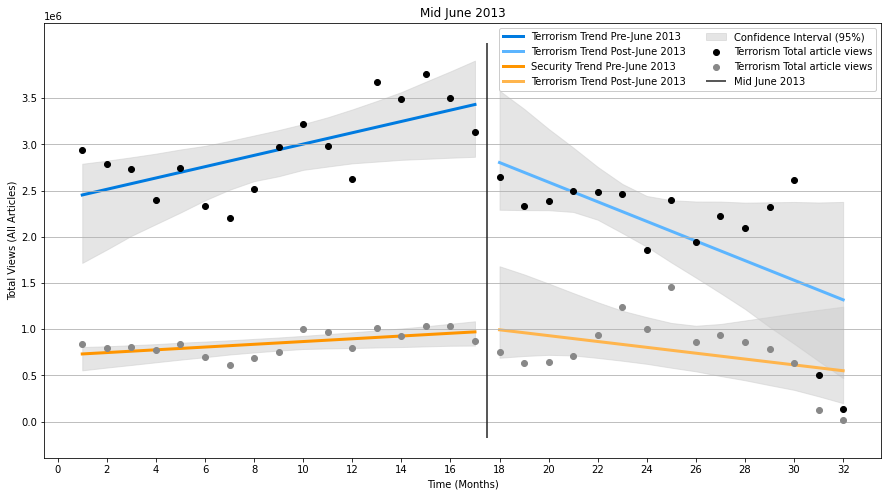

In [18]:
plot_replication_4(all_views_month_clean, dom_views_month, sample_size=15, idx_max=32)

The replication presented here exhibits the same trends as the figure 4A in the paper but not wih exactly the same results.
We can note that the confidence intervals are much larger on the ends after June 2013 for my version than for the version of the paper. As was discussed in the previous replication (figure 3), the last two months have some very low values that we might want to exclude.

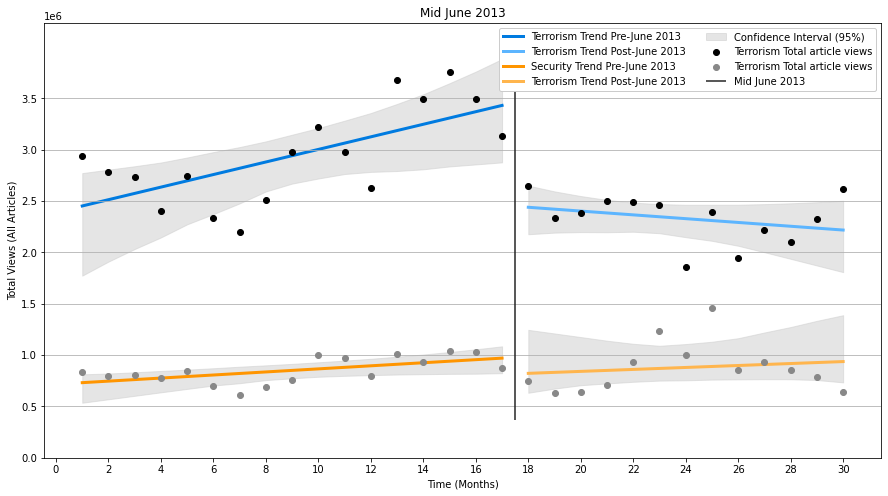

In [19]:
plot_replication_4(all_views_month_clean, dom_views_month, sample_size=15, idx_max=30)

Excluding the values of the last two months we get the figure above which is closer to the one in the paper. We can see that the slope on the terrorism articles after June 2013 is lower than in the paper. Also it seams that the regression line on the Domestic Security related articles in ging slightly up, where in the paper it is clearly going down.

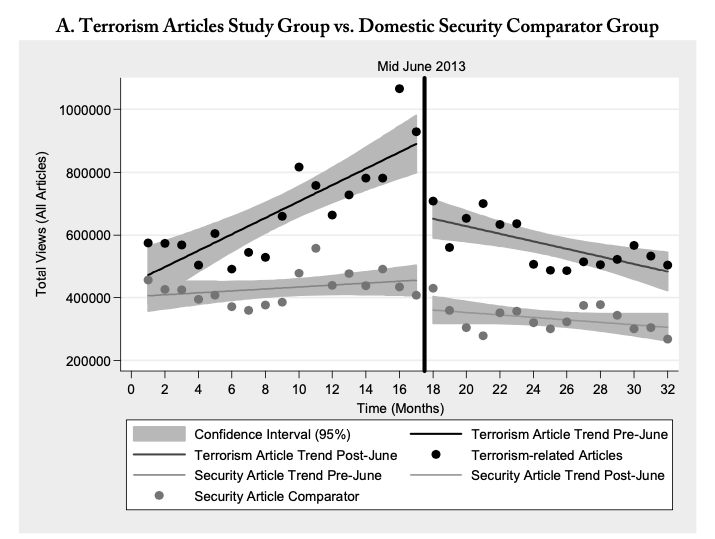

In [20]:
display(Image(filename='./images/Figure4A.png', width=500))

---